In [2]:
from gurobipy import Model, GRB
import pandas as pd
import numpy as np
import math

In [3]:
def find_lambda(spd,prob):
    # Find lambda by using gurobi 
    # WT* = piT(s)^-1 * lambda

    pi = spd  # Example values, replace with your actual pi values
    
    # Create a new model
    model = Model("lambda_model")

    lambda_var = 0.01
    increment = 0.01
    val_min = 5
    lambda_min = 0
    for j in range(10000):
        val = sum(1/lambda_var * prob[i] for i in range(len(pi)))
        if val - 1 < 0.001:
            return lambda_var
        else:
            if val < val_min:
                val_min = val
                lambda_min = lambda_var
            lambda_var += increment
    return lambda_min


In [4]:
def get_stock_evolution(S0,T,u,d):
    # Get stock evolution
    # S0: initial stock price
    # T: number of periods
    # u: up factor
    # d: down factor
    # Initialize stock evolution
    stock_evolution = np.zeros((T+1,T+1))

    # Set initial stock price
    stock_evolution[0,0] = S0

    # Loop through each period
    for i in range(1,T+1):
        # Loop through each node in the period
        for j in range(i+1):
            # Set stock price
            stock_evolution[j,i] = S0 * u**(i-j) * d**(j)

    return stock_evolution

In [5]:
def get_terminal_wealth(u,d,pi_u,pi_d,S0,T,lambda_var):
    terminal_stock_prices = []
    terminal_wealth = []
    for i in range(T+1):
        s_T = S0 * u**(T-i) * d**(i)
        lnpi_T = T*np.log(pi_u)+(np.log(pi_u)-np.log(pi_d))*(np.log(s_T)-np.log(S0)-T*np.log(d))/(np.log(u)-np.log(d))
        w_T = 1/(np.exp(lnpi_T)*lambda_var)
        terminal_wealth.append(w_T)
    return terminal_wealth

In [6]:
def run_simulation(sigma, mu, periods, S0, risk_free):
    # sigma_implied: implied volatility
    # sigma_historical: historical volatility
    # historical_mean: historical mean
    # risk free: risk free rate

    # return: weight of the portfolio that should be allocated to the risky asset (stock)

    # Initialize parameters
    
    dt = 1/12
    risk_free = risk_free/12
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p_u = (np.exp(dt*mu)-d)/(u-d)
    p_d = 1-p_u
    q_u = ((1+risk_free)-d)/(u-d)
    q_d = 1-q_u
    pi_u = q_u/(p_u*(1+risk_free))
    pi_d = q_d/(p_d*(1+risk_free))


    # Calculate terminal values
    probability = []
    spd = []
    
    for i in range(periods+1):
        spd.append(pi_u**i * pi_d**(periods-i))
        probability.append(math.comb(periods,i)*pi_u**i * pi_d**(periods-i))
    
    probability = np.array(probability)
    spd = np.array(spd)

    # Get terminal wealth
    lambda_var = find_lambda(spd,probability)
    stock_evolution = get_stock_evolution(S0,periods,u,d)
    terminal_wealth = get_terminal_wealth(u,d,pi_u,pi_d,S0,periods,lambda_var)

    # Discount the terminal wealth back to time 0
    discount_rate = dt * risk_free
    terminal_wealth_final = []
    for i in range(periods-2):
        terminal_wealth_temp = []
        for j in range(len(terminal_wealth)-1):
            terminal_wealth_temp.append(1/(1+discount_rate) * (terminal_wealth[j]*q_u + terminal_wealth[j+1]*q_d))
        terminal_wealth_final.append(terminal_wealth_temp)
    
    # Find the delta
    return (terminal_wealth_final[-1][0]-terminal_wealth_final[-1][1])/(u-d)
    

In [7]:
def rebalance(initial_portfolio_value, initial_weight_in_stock,initial_weight_in_bond, new_weight_in_stock):
    # Calculate the amount of money that should be allocated to the risky asset (stock) to rebalance the portfolio
    return initial_portfolio_value * (new_weight_in_stock - initial_weight_in_stock) / (initial_weight_in_stock - initial_weight_in_bond)

In [8]:
def model_period(initial_portfolio_value, stock_value_array, sigma_array, historical_mean_array, risk_free_array, time_frame):
    # Do sanity checks
    if len(sigma_array) != len(historical_mean_array) or len(sigma_array) != len(risk_free_array) or len(sigma_array) != time_frame:
        raise Exception("The length of the inputs are not equal")
    # Run each simulation

    new_weight_in_stock = run_simulation(sigma_array[0], historical_mean_array[0], time_frame, stock_value_array[0], risk_free_array[0])
    
    portfolio_value = [initial_portfolio_value]
    weights = []
    initial_weight_in_stock = new_weight_in_stock
    initial_weight_in_bond = 1 - new_weight_in_stock
    initial_number_of_shares = initial_weight_in_stock * initial_portfolio_value / stock_value_array[0]
    initial_value_of_shares = initial_weight_in_stock * initial_portfolio_value
    initial_value_of_bonds = initial_weight_in_bond * initial_portfolio_value
    amount_stock_rebalanced = 0
    for i in range(1,time_frame):
        initial_portfolio_value = initial_number_of_shares * stock_value_array[i] + initial_value_of_bonds * (1+risk_free_array[i-1]/12)
        portfolio_value.append(initial_portfolio_value)
        new_weight_in_stock = run_simulation(sigma_array[i], historical_mean_array[i], time_frame, stock_value_array[i], risk_free_array[i])
        weights.append(new_weight_in_stock)
        
        # Update the portfolio
        amount_stock_rebalanced += abs((new_weight_in_stock-initial_weight_in_stock)*initial_portfolio_value/stock_value_array[i])
        initial_weight_in_stock = new_weight_in_stock
        initial_weight_in_bond = 1 - new_weight_in_stock
        initial_number_of_shares = initial_weight_in_stock * initial_portfolio_value / stock_value_array[0]
        initial_value_of_shares = initial_weight_in_stock * initial_portfolio_value
        initial_value_of_bonds = initial_weight_in_bond * initial_portfolio_value
    # print(weights,"\n",stock_value_array,"\n",sigma_array,"\n\n")
    return portfolio_value,amount_stock_rebalanced,weights


In [9]:
df = pd.read_csv("full_data_final_merged_data.csv")
df.shape

(169, 7)

In [10]:
# Variables to adjust
# Periods must be between 1 and 169
periods = 6
initial_portfolio_value = 10000

# loop through the dataframe
results_implied = []
results_historical = []
rebalanced_implied = []
rebalanced_historical = []
dates = []
weights_implied = []
weights_historical = []

for i in range(0, df.shape[0]-periods+1):
    # Get the data ==============================================================
    # General data for this period
    date = df["Date"][i]
    mu = df["Expected Mean"][i:i+periods].tolist()
    rf = df["RF"][i:i+periods].tolist()
    adj_close = df["Adj Close"][i:i+periods].tolist()

    # Vols
    sigma_implied = df["Implied Vols"][i:i+periods].tolist()
    sigma_historical = df["Historical Volatility"][i:i+periods].tolist()

    # Run the model =============================================================
    a = model_period(initial_portfolio_value, adj_close, sigma_implied, mu, rf, periods)
    b = model_period(initial_portfolio_value, adj_close, sigma_historical, mu, rf, periods)
    
    # Print the results =========================================================
    
    results_implied.append(a[0])
    results_historical.append(b[0])
    rebalanced_implied.append(a[1])
    rebalanced_historical.append(b[1])
    weights_implied.append(a[2])
    weights_historical.append(b[2])
    dates.append(date)
    
print("using implied:\nmean of portfolio with initial value 10000: ",np.mean([results_implied[i][-1] for i in range(len(results_implied))]),"\nstdev: ",np.std(results_implied),"\nshares rebalanced: ",np.mean(rebalanced_implied),"\n")
print("using historical:\nmean of portfolio with initial value 10000: ",np.mean([results_historical[i][-1] for i in range(len(results_historical))]),"\nstdev: ",np.std(results_historical),"\nshares rebalanced: ",np.mean(rebalanced_historical))
    

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-01
using implied:
mean of portfolio with initial value 10000:  11560.272945125642 
stdev:  1764.2076673597048 
shares rebalanced:  106.95737287047581 

using historical:
mean of portfolio with initial value 10000:  11993.618870875554 
stdev:  3148.453009535743 
shares rebalanced:  80.95997046125969


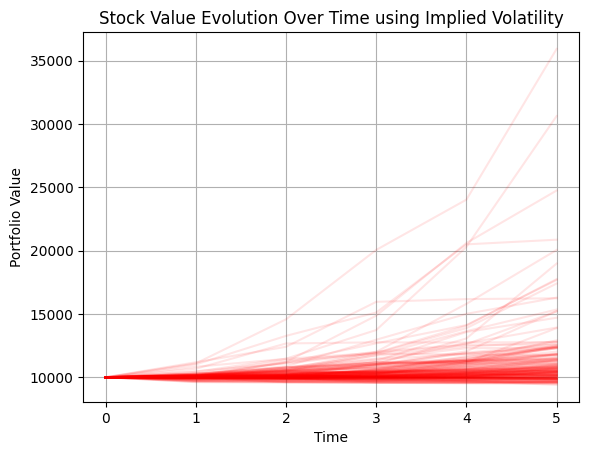

In [11]:
import matplotlib.pyplot as plt

# Plot results_implied using a collection
for portfoliopath in results_implied:
    plt.plot(portfoliopath,color = "red", alpha = 0.1)  # Plot each stock

# Customizing the plot
plt.title('Stock Value Evolution Over Time using Implied Volatility')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.grid(True)

# Show the plot
plt.show()

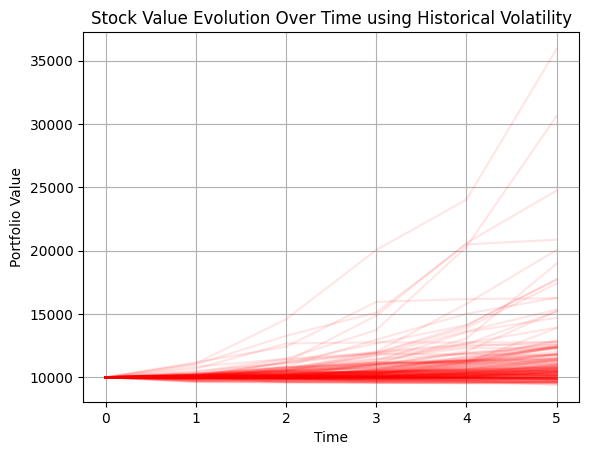

In [12]:
import matplotlib.pyplot as plt

# Plot results_implied using a collection
for portfoliopath in results_implied:
    plt.plot(portfoliopath,color = "red", alpha = 0.1)  # Plot each stock

# Customizing the plot
plt.title('Stock Value Evolution Over Time using Historical Volatility')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.grid(True)

# Show the plot
plt.show()

In [13]:
print("Average Stdev Implied: ",np.mean([np.std(results_implied[i]) for i in range(len(results_implied))]),"\nAverage Stdev Historical: ",np.mean([np.std(results_historical[i]) for i in range(len(results_historical))]))


Average Stdev Implied:  617.8802035173818 
Average Stdev Historical:  806.0081053768732


In [19]:
final_results = pd.DataFrame()

vix = pd.read_csv("VIX.csv",usecols=["Date","Adj Close"])

final_results["Date"] = df["Date"][:-5]
final_results["Implied"] = [results_implied[i][-1] for i in range(len(results_implied))]
final_results["Historical"] = [results_historical[i][-1] for i in range(len(results_historical))]
final_results["Delta"] = np.array([results_implied[i][-1] for i in range(len(results_implied))])-np.array([results_historical[j][-1] for j in range(len(results_historical))])
final_results["Mu"] = df["Expected Mean"][:-5]
final_results["RF"] = df["RF"][:-5]
final_results["Sigma Implied"] = df["Implied Vols"][:-5]
final_results["Sigma Historical"] = df["Historical Volatility"][:-5]
final_results["Adj Close"] = df["Adj Close"][:-5]
final_results.rename(columns = {"Adj Close":"Stock Price"},inplace=True)
final_results["Weights_implied"] = weights_implied
final_results["Weights_historical"] = weights_historical
final_results["Results Implied"] = results_implied
final_results["Results Historical"] = results_historical
final_results["Rebalanced Implied"] = rebalanced_implied
final_results["Rebalanced Historical"] = rebalanced_historical
final_results["Amount Stock Rebalanced Implied"] = rebalanced_implied
final_results["Amount Stock Rebalanced Historical"] = rebalanced_historical

final_results = pd.merge(final_results,vix,on="Date",how="right")
final_results.rename(columns={"Adj Close":"VIX"},inplace=True)
# Remove all rows with NaN
final_results = final_results.dropna()
final_results.reset_index(inplace=True,drop=True)

final_results.to_csv("final_results.csv",index=False)

final_results.head()

,Date,Implied,Historical,Delta,Mu,RF,Sigma Implied,Sigma Historical,Stock Price,Weights_implied,Weights_historical,Results Implied,Results Historical,Rebalanced Implied,Rebalanced Historical,Amount Stock Rebalanced Implied,Amount Stock Rebalanced Historical,VIX
0,2008-01-04,9977.652215,9963.237613,14.414602,0.08270,0.02520,0.233642,0.193740,104.107941,"[0.05969438634578591, 0.037711834317073166, 0....","[0.08108842523954722, 0.09226415458796344, 0.0...","[10000, 10013.665796573925, 9978.43780147759, ...","[10000, 10007.839884946368, 9954.741765973058,...",20.439594,6.370333,20.439594,6.370333,23.940001
1,2008-02-01,9959.290721,9938.849204,20.441516,0.07514,0.01764,0.221913,0.201272,102.833397,"[0.037711834317073166, 0.06193798775817741, 0....","[0.09226415458796344, 0.06401299183229793, 0.0...","[10000, 9971.611410636895, 9984.325425055875, ...","[10000, 9956.16876999441, 9960.006065597425, 9...",19.711876,5.845626,19.711876,5.845626,24.020000
2,2008-03-07,10206.215790,10190.453587,15.762204,0.08018,0.02268,0.258626,0.193376,95.561844,"[0.06193798775817741, 0.1400885742332849, 0.06...","[0.06401299183229793, 0.06405243191865014, 0.0...","[10000, 10041.0324224059, 10116.79308745024, 1...","[10000, 10073.048234347216, 10151.029703321099...",18.042535,5.528161,18.042535,5.528161,27.490000
3,2008-04-04,9867.048565,9821.304739,45.743826,0.07766,0.02016,0.219333,0.217011,101.350815,"[0.1400885742332849, 0.06464521790159843, 0.06...","[0.06405243191865014, 0.0781443899683146, 0.08...","[10000, 10036.663763196984, 10045.001474566001...","[10000, 10037.329225396403, 10050.294320958077...",21.515056,7.263776,21.515056,7.263776,22.450001
4,2008-05-02,9703.465587,9585.836225,117.629362,0.07766,0.02016,0.170375,0.216969,104.771446,"[0.06464521790159843, 0.06546635381902212, 0.0...","[0.0781443899683146, 0.08292238930029569, 0.07...","[10000, 9962.770867332281, 9911.436954095025, ...","[10000, 9992.096362599425, 9926.354888189662, ...",14.501172,11.187650,14.501172,11.187650,18.180000


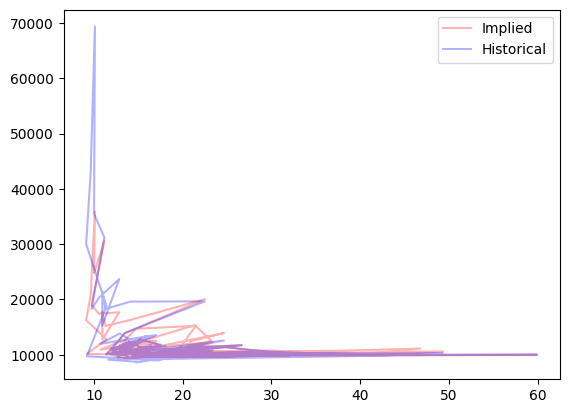

In [15]:
plt.plot(final_results["VIX"],final_results["Implied"],color = "red",alpha = 0.3)
plt.plot(final_results["VIX"],final_results["Historical"],color = "blue",alpha = 0.3)
plt.legend(["Implied","Historical"])
plt.show()

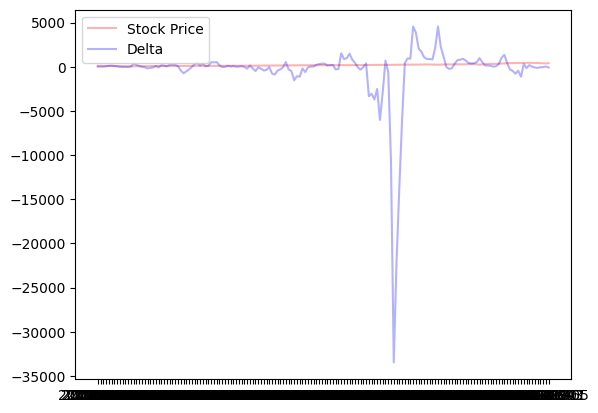

In [16]:
# plot stock price and Delta over time
plt.plot(final_results["Date"],final_results["Stock Price"],color = "red",alpha = 0.3)
plt.plot(final_results["Date"],final_results["Delta"],color = "blue",alpha = 0.3)
plt.legend(["Stock Price","Delta"])
plt.show()

Percentage of time that the implied strategy underperforms when both portfolios lost money:  18.571 %


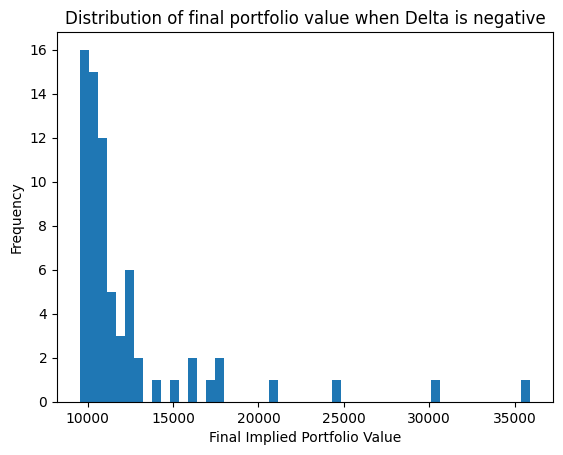

In [17]:
negative_delta = final_results[final_results["Delta"]<0]
negatives = 0
historical_list = negative_delta["Historical"].to_list()
# print(negative_delta)
for i in historical_list:
    if i < 10000:
        negatives += 1
print("Percentage of time that the implied strategy underperforms when both portfolios lost money: ",round(negatives/len(negative_delta)*100,3),"%")
plt.hist(negative_delta["Implied"],bins=50)
plt.title("Distribution of final portfolio value when Delta is negative")
plt.ylabel("Frequency")
plt.xlabel("Final Implied Portfolio Value")
# add a note to the plot
plt.show()

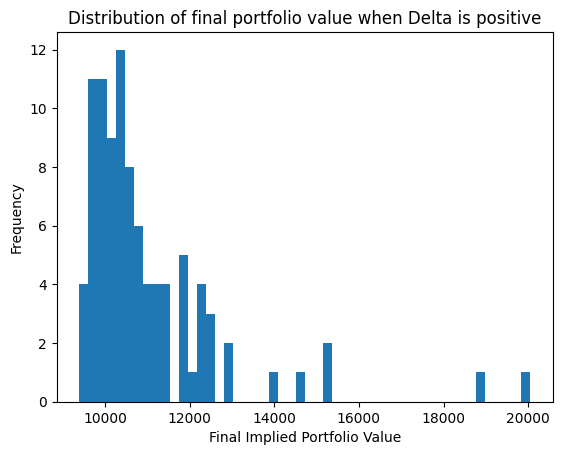

In [270]:
positive_delta = final_results[final_results["Delta"]>0]
plt.hist(positive_delta["Implied"],bins=50)
plt.title("Distribution of final portfolio value when Delta is positive")
plt.ylabel("Frequency")
plt.xlabel("Final Implied Portfolio Value")
plt.show()

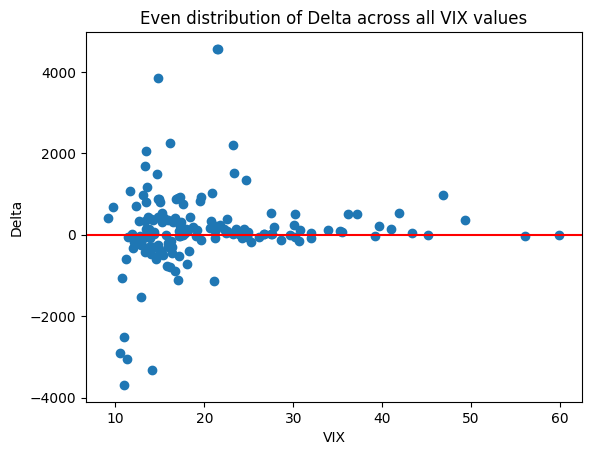

In [18]:
# plot vix vs delta
remove_large_losses = final_results[final_results["Delta"]>-5000]
plt.scatter(remove_large_losses["VIX"],remove_large_losses["Delta"])
plt.xlabel("VIX")
plt.ylabel("Delta")
plt.title("Even distribution of Delta across all VIX values")
# add a horizontal line to the plot at 0
plt.axhline(y=0, color='r', linestyle='-')
plt.show()